In [1]:
import os
import io
import math
import time
import pprint as pp
import tempfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [11]:
from PIL import Image
from six import BytesIO
from IPython import display
from urllib.request import urlopen

In [12]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2.17.0
Num GPUs Available:  2


In [13]:
import tensorflow_models as tfm
from tensorflow.python.keras.utils import tf_utils
from official.core import exp_factory
from official.core import train_lib
from official.vision.serving import export_saved_model_lib
from official.vision.ops.preprocess_ops import normalize_image
from official.vision.ops.preprocess_ops import resize_and_crop_image
from official.vision.utils.object_detection import visualization_utils
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder

In [14]:
#export TF_FORCE_GPU_ALLOW_GROWTH="true"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


Convert COCO Json to TFRecord (run in powershell)

In [15]:
# $TRAIN_DATA_DIR = 'C:\Python\PyProjects\CNNS\TFMyotubeSSD\TFRecord.v1i.coco\train'
# $TRAIN_ANNOTATION_FILE_DIR = 'C:\Python\PyProjects\CNNS\TFMyotubeSSD\TFRecord.v1i.coco\train\_annotations.coco.json'
# $OUTPUT_TFRECORD_TRAIN = 'C:\Python\PyProjects\CNNS\TFMyotubeSSD\TfRecords\train'
# 
# # Run the Python script
# python -m official.vision.data.create_coco_tf_record --logtostderr `
#   --image_dir=$TRAIN_DATA_DIR `
#   --object_annotations_file=$TRAIN_ANNOTATION_FILE_DIR `
#   --output_file_prefix=$OUTPUT_TFRECORD_TRAIN `
#   --num_shards=1

In [16]:
# $VALID_DATA_DIR = 'C:\Python\PyProjects\CNNS\TFMyotubeSSD\TFRecord.v1i.coco\valid'
# $VALID_ANNOTATION_FILE_DIR = 'C:\Python\PyProjects\CNNS\TFMyotubeSSD\TFRecord.v1i.coco\valid\_annotations.coco.json'
# $OUTPUT_TFRECORD_TRAIN = 'C:\Python\PyProjects\CNNS\TFMyotubeSSD\TfRecords\valid'
# 
# # Run the Python script
# python -m official.vision.data.create_coco_tf_record --logtostderr `
#   --image_dir=$VALID_DATA_DIR `
#   --object_annotations_file=$VALID_ANNOTATION_FILE_DIR `
#   --output_file_prefix=$OUTPUT_TFRECORD_VALID `
#   --num_shards=1

In [17]:
# $TEST_DATA_DIR = 'C:\Python\PyProjects\CNNS\TFMyotubeSSD\TFRecord.v1i.coco\test'
# $TEST_ANNOTATION_FILE_DIR = 'C:\Python\PyProjects\CNNS\TFMyotubeSSD\TFRecord.v1i.coco\test\_annotations.coco.json'
# $OUTPUT_TFRECORD_TRAIN = 'C:\Python\PyProjects\CNNS\TFMyotubeSSD\TfRecords\test'
# 
# # Run the Python script
# python -m official.vision.data.create_coco_tf_record --logtostderr `
#   --image_dir=$TEST_DATA_DIR `
#   --object_annotations_file=$TEST_ANNOTATION_FILE_DIR `
#   --output_file_prefix=$OUTPUT_TFRECORD_TEST `
#   --num_shards=1

In [18]:
train_data_input_path = 'TfRecords/BestImagesV2/train/BestImagesV2-00000-of-00001.tfrecord'
valid_data_input_path = 'TfRecords/BestImagesV2/valid/BestImagesV2-00000-of-00001.tfrecord'
test_data_input_path = 'TfRecords/BestImagesV2/test/BestImagesV2-00000-of-00001.tfrecord'
model_dir = './trained_model/'
export_dir ='./exported_model/'

In [19]:
#!wget "https://storage.googleapis.com/tf_model_garden/vision/resnet/resnet-50-i224.tar.gz"
exp_config = exp_factory.get_exp_config('retinanet_resnetfpn_coco')

In [20]:
batch_size = 12
num_classes = 1

HEIGHT, WIDTH = 640, 640
IMG_SIZE = [HEIGHT, WIDTH, 3]

# Backbone config.
transfering_learning_folder="transfering-learning-models/"
resnet=transfering_learning_folder+"resnet-50-i224/ckpt-62400"
mobilenet=transfering_learning_folder+"mobilenet/ckpt-180648"


exp_config.task.init_checkpoint = resnet
exp_config.task.init_checkpoint_modules ="backbone"
exp_config.task.freeze_backbone = True
exp_config.task.annotation_file = None

# Model config.
exp_config.task.model.input_size = IMG_SIZE
exp_config.task.model.num_classes = num_classes + 1
exp_config.task.model.detection_generator.tflite_post_processing.max_classes_per_detection = exp_config.task.model.num_classes

# Training data config.
exp_config.task.train_data.input_path = train_data_input_path
exp_config.task.train_data.dtype = 'float32'
exp_config.task.train_data.global_batch_size = batch_size
# exp_config.task.train_data.parser.aug_scale_max = 1.5
# exp_config.task.train_data.parser.aug_scale_min = 0.6
# exp_config.task.train_data.parser.aug_rand_hflip = True 

exp_config.task.train_data.parser.aug_rand_hflip = True         # Random horizontal flip
exp_config.task.train_data.parser.aug_scale_max = 1.5           # Max scaling factor
exp_config.task.train_data.parser.aug_scale_min = 0.6           # Min scaling factor
exp_config.task.train_data.parser.aug_rand_rotation = 15        # Rotation in degrees
exp_config.task.train_data.parser.aug_rand_crop = True          # Random cropping
exp_config.task.train_data.parser.aug_aspect_ratio_min = 0.75   # Min aspect ratio adjustment
exp_config.task.train_data.parser.aug_aspect_ratio_max = 1.25   # Max aspect ratio adjustment


# Validation data config.
exp_config.task.validation_data.input_path = valid_data_input_path
exp_config.task.validation_data.dtype = 'float32'
exp_config.task.validation_data.global_batch_size = batch_size

<h3>Adjust the trainer configuration.</h3>

In [21]:
logical_device_names = [logical_device.name for logical_device in tf.config.list_logical_devices()]

if 'GPU' in ''.join(logical_device_names):
  print('Running with GPU.')
  device = 'GPU'
elif 'TPU' in ''.join(logical_device_names):
  print('Running with TPU.')
  device = 'TPU'
else:
  print('Running on CPU is slow, so only train for a few steps.')
  device = 'CPU'
train_steps = 10000 #---
exp_config.trainer.steps_per_loop = 100 # steps_per_loop = num_of_training_examples // train_batch_size
checkpoint_interval=100

exp_config.trainer.summary_interval = 100
exp_config.trainer.checkpoint_interval = checkpoint_interval
exp_config.trainer.validation_interval = 500  
exp_config.trainer.validation_steps =  100
exp_config.trainer.max_to_keep=train_steps/checkpoint_interval
exp_config.trainer.train_steps = train_steps
exp_config.trainer.optimizer_config.warmup.linear.warmup_steps = 200 #---
exp_config.trainer.optimizer_config.learning_rate.type = 'cosine'
exp_config.trainer.optimizer_config.learning_rate.cosine.decay_steps = train_steps
exp_config.trainer.optimizer_config.learning_rate.cosine.initial_learning_rate = 0.001 #---
exp_config.trainer.optimizer_config.warmup.linear.warmup_learning_rate = 0.0001 #---

#Lowest Validation Loss Experiment
#Best Hyperparameters: {'initial_learning_rate': 0.001, 'warmup_learning_rate': 1e-06, 'warmup_steps': 500, 'train_steps': 10000}
# train_steps = 10000 #---
# exp_config.trainer.steps_per_loop = 100 # steps_per_loop = num_of_training_examples // train_batch_size

# exp_config.trainer.summary_interval = 100
# exp_config.trainer.checkpoint_interval = 100
# exp_config.trainer.validation_interval = 500  
# exp_config.trainer.validation_steps =  100
# exp_config.trainer.train_steps = train_steps
# exp_config.trainer.optimizer_config.warmup.linear.warmup_steps = 500 #---
# exp_config.trainer.optimizer_config.learning_rate.type = 'cosine'
# exp_config.trainer.optimizer_config.learning_rate.cosine.decay_steps = train_steps
# exp_config.trainer.optimizer_config.learning_rate.cosine.initial_learning_rate = 0.001 #---
# exp_config.trainer.optimizer_config.warmup.linear.warmup_learning_rate = 0.000001 #---

Running with GPU.


In [22]:
pp.pprint(exp_config.as_dict())
display.Javascript('google.colab.output.setIframeHeight("500px");')

{'runtime': {'all_reduce_alg': None,
             'batchnorm_spatial_persistent': False,
             'dataset_num_private_threads': None,
             'default_shard_dim': -1,
             'distribution_strategy': 'mirrored',
             'enable_xla': False,
             'gpu_thread_mode': None,
             'loss_scale': None,
             'mixed_precision_dtype': 'bfloat16',
             'num_cores_per_replica': 1,
             'num_gpus': 0,
             'num_packs': 1,
             'per_gpu_thread_count': 0,
             'run_eagerly': False,
             'task_index': -1,
             'tpu': None,
             'tpu_enable_xla_dynamic_padder': None,
             'use_tpu_mp_strategy': False,
             'worker_hosts': None},
 'task': {'allow_image_summary': False,
          'annotation_file': None,
          'differential_privacy_config': None,
          'export_config': {'cast_detection_classes_to_float': False,
                            'cast_num_detections_to_float': False

<IPython.core.display.Javascript object>

In [23]:
if exp_config.runtime.mixed_precision_dtype == tf.float16:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled with float16.")

if 'GPU' in ''.join(logical_device_names):
  tf.keras.mixed_precision.set_global_policy('mixed_float16')
  distribution_strategy = tf.distribute.MirroredStrategy()
  print("Running on GPU with MirroredStrategy.")
    
elif 'TPU' in ''.join(logical_device_names):
  tf.tpu.experimental.initialize_tpu_system()
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='/device:TPU_SYSTEM:0')
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
  print('Warning: this will be really slow.')
  distribution_strategy = tf.distribute.OneDeviceStrategy(logical_device_names[0])

print('Done')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Running on GPU with MirroredStrategy.
Done


In [24]:
with distribution_strategy.scope():
  task = tfm.core.task_factory.get_task(exp_config.task, logging_dir=model_dir)

In [25]:
for images, labels in task.build_inputs(exp_config.task.train_data).take(1):
  print()
  print(f'images.shape: {str(images.shape):16}  images.dtype: {images.dtype!r}')
  print(f'labels.keys: {labels.keys()}')


images.shape: (12, 512, 512, 3)  images.dtype: tf.float32
labels.keys: dict_keys(['cls_targets', 'box_targets', 'anchor_boxes', 'cls_weights', 'box_weights', 'image_info'])


2024-11-20 16:25:51.038056: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [26]:
category_index={
    1: {
        'id': 1,
        'name': 'Mature-Myotube'
       }
}
tf_ex_decoder = TfExampleDecoder()

In [27]:
def show_batch(raw_records, num_of_examples):
    plt.figure(figsize=(20, 20))
    use_normalized_coordinates = True
    min_score_thresh = 0.30
    
    # Calculate the number of rows and columns based on the number of examples
    num_cols = 3  # You can change this if you want more columns
    num_rows = math.ceil(num_of_examples / num_cols)
    
    for i, serialized_example in enumerate(raw_records):
        if i >= num_of_examples:  # Stop if the number of examples exceeds the limit
            break
        
        # Adjust the subplot grid dynamically
        plt.subplot(num_rows, num_cols, i + 1)
        
        decoded_tensors = tf_ex_decoder.decode(serialized_example)
        image = decoded_tensors['image'].numpy().astype('uint8')
        scores = np.ones(shape=(len(decoded_tensors['groundtruth_boxes'])))
        
        visualization_utils.visualize_boxes_and_labels_on_image_array(
            image,
            decoded_tensors['groundtruth_boxes'].numpy(),
            decoded_tensors['groundtruth_classes'].numpy().astype('int'),
            scores,
            category_index=category_index,
            use_normalized_coordinates=use_normalized_coordinates,
            max_boxes_to_draw=200,
            min_score_thresh=min_score_thresh,
            agnostic_mode=False,
            instance_masks=None,
            line_thickness=4)
        
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'Image-{i + 1}')
    
    plt.show()

2024-11-16 23:58:28.335425: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


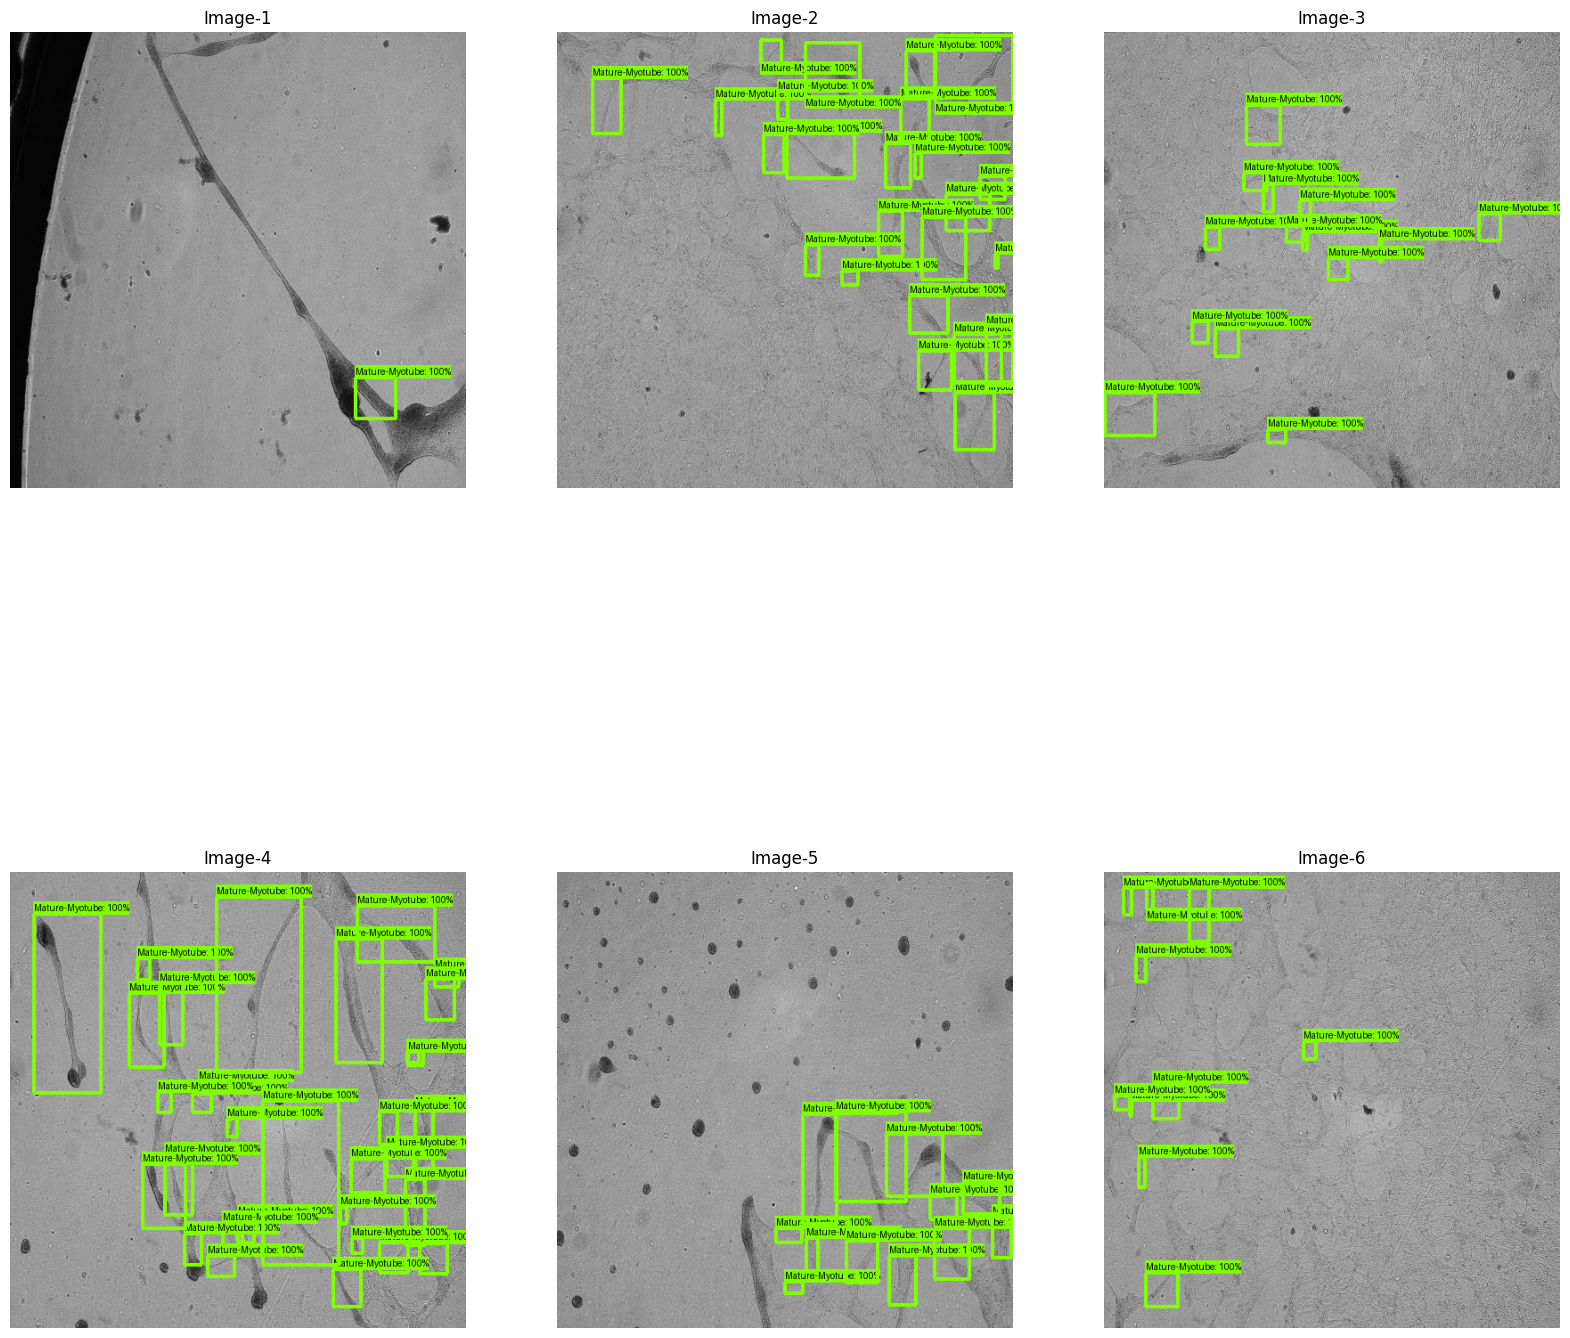

In [19]:
%matplotlib inline
buffer_size = 100
num_of_examples = 6

raw_records = tf.data.TFRecordDataset(
    exp_config.task.train_data.input_path).shuffle(
        buffer_size=buffer_size).take(num_of_examples)
show_batch(raw_records, num_of_examples)

<h3>Train and evaluate</h3>

In [20]:
start_time = time.time()

model, eval_logs = train_lib.run_experiment( distribution_strategy=distribution_strategy, task=task, mode='train_and_eval', params=exp_config, model_dir=model_dir, run_post_eval=True)

end_time = time.time()
#Calculate elapsed time

elapsed_time = end_time - start_time
#Convert to hours, minutes, and seconds

hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)

print(f"Training completed in {int(hours)} hours, {int(minutes)} minutes, and {seconds:.2f} seconds.")


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


restoring or initializing model...
INFO:tensorflow:Customized initialization is done through the passed `init_fn`.


INFO:tensorflow:Customized initialization is done through the passed `init_fn`.


train | step:      0 | training until step 500...
INFO:tensorflow:Collective all_reduce tensors: 126 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 126 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 126 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 126 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
2024-11-16 23:58:54.503217: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-11-16 23:58:54.888787: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1731823134.905840   22114 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731823134.938321   22112 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731823135.198070   22114 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731823135.201827   22112 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731823135.225521   22114 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W000

InternalError: Graph execution error:

Detected at node SGD/CollectiveReduceV2 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_21965/3841504660.py", line 3, in <module>

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/official/core/train_lib.py", line 372, in run_experiment

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/official/core/train_lib.py", line 271, in run

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/orbit/controller.py", line 393, in train_and_evaluate

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/orbit/controller.py", line 282, in train

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/orbit/controller.py", line 517, in _train_n_steps

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/orbit/standard_runner.py", line 146, in train

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/orbit/utils/loop_fns.py", line 116, in loop_fn

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/orbit/utils/loop_fns.py", line 120, in loop_fn

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/official/core/base_trainer.py", line 400, in train_step

  File "/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/optimizers/utils.py", line 172, in _all_reduce_sum_fn

Collective ops is aborted by: NCCL: unhandled cuda error (run with NCCL_DEBUG=INFO for details). Set NCCL_DEBUG=WARN for detail.
The error could be from a previous operation. Restart your program to reset.
	 [[{{node SGD/CollectiveReduceV2}}]] [Op:__inference_loop_fn_51919]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir './trained_model/'

<h3>Saving and exporting the trained model.</h3>

In [ ]:
print(eval_logs)

In [28]:
export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[HEIGHT, WIDTH],
    params=exp_config,
    checkpoint_path=tf.train.latest_checkpoint(model_dir),
    export_dir=export_dir)

INFO:tensorflow:Assets written to: ./exported_model/assets


INFO:tensorflow:Assets written to: ./exported_model/assets


<h3>Inference from trained model</h3>

In [29]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

def build_inputs_for_object_detection(image, input_image_size):
  """Builds Object Detection model inputs for serving."""
  image, _ = resize_and_crop_image(
      image,
      input_image_size,
      padded_size=input_image_size,
      aug_scale_min=1.0,
      aug_scale_max=1.0)
  image = tf.cast(image, dtype=tf.uint8)
  return image

<h3>Visualize test data.</h3>

In [30]:
num_of_examples = 10

test_ds = tf.data.TFRecordDataset(
    'TfRecords/BestImagesV2/test/BestImagesV2-00000-of-00001.tfrecord').take(
        num_of_examples)
show_batch(test_ds, num_of_examples)

2024-11-20 16:26:50.450710: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/tmp/ipykernel_119161/1100200257.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


<h3>Importing SavedModel.</h3>

In [31]:
imported = tf.saved_model.load(export_dir)
#imported = tf.saved_model.load("PHI8IMages_exported_model")
model_fn = imported.signatures['serving_default']

<h3>Visualize predictions.</h3>

In [32]:
HEIGHT, WIDTH = 640, 640
input_image_size = (HEIGHT, WIDTH)
plt.figure(figsize=(50, 50))
min_score_thresh = 0.10  # Set score threshold to display bounding boxes
iou_threshold = 0.30      # IoU threshold for Non-Max Suppression
max_boxes = 50 # Maximum number of boxes after NMS

num_elements = sum(1 for _ in test_ds)
num_cols = 3
num_rows = math.ceil(num_elements / num_cols)

for i, serialized_example in enumerate(test_ds):
    plt.subplot(num_rows, num_cols, i + 1)
    decoded_tensors = tf_ex_decoder.decode(serialized_example)
    image = build_inputs_for_object_detection(decoded_tensors['image'], input_image_size)
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, dtype = tf.uint8)
    image_np = image[0].numpy()
    result = model_fn(image)


    detection_boxes = result['detection_boxes'][0].numpy()
    detection_classes = result['detection_classes'][0].numpy().astype(int)
    detection_scores = result['detection_scores'][0].numpy()

    # print("detection_boxes: ",detection_boxes)
    # print("detection_classes: ",detection_classes)
    # print("detection_scores: ",detection_scores)


    selected_indices = tf.image.non_max_suppression(
        boxes=detection_boxes,
        scores=detection_scores,
        max_output_size=max_boxes,
        iou_threshold=iou_threshold,
        score_threshold=min_score_thresh
    )
    selected_boxes = tf.gather(detection_boxes, selected_indices).numpy()
    selected_classes = tf.gather(detection_classes, selected_indices).numpy()
    selected_scores = tf.gather(detection_scores, selected_indices).numpy()

    
    
    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image_np,
        selected_boxes,
        selected_classes,
        selected_scores,
        category_index=category_index,
        use_normalized_coordinates=False,
        max_boxes_to_draw=max_boxes,
        min_score_thresh=min_score_thresh,
        agnostic_mode=True,
        instance_masks=None,
        line_thickness=1
    )

    
    plt.imshow(image_np)
    plt.axis('off')

plt.show()

2024-11-20 16:27:08.432653: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1732141628.813939  121498 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732141629.178703  121498 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732141629.247418  121498 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732141629.278100  121498 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732141629.366579  121498 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732141629.428168  121498 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732141629.429249  121498 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732141629.430701  121498 gpu_t

<h3>Inference over images</h3>

In [2]:
HEIGHT, WIDTH = 512, 512  # Fixed image size expected by the model
input_image_size = (HEIGHT, WIDTH)

min_score_thresh = 0.30  # Set score threshold to display bounding boxes
iou_threshold = 0.30    # IoU threshold for Non-Max Suppression
max_boxes = 20 # Maximum number of boxes after NMS



image_paths = [
    "images/7aa701b6-Gannon_2024-08-16_18-23-17_A2_02_06__Best_png.rf.8594e106fdc12c0cca4de0f4d1f0d038.jpg"
]
for i, image_path in enumerate(image_paths):
    # Correct the image path if needed
    
    image_name=image_path[0:image_path.find('.')]
    
    #image_path = "images/" + image_path

    # 1. Load the image into a NumPy array
    image_np = load_image_into_numpy_array(image_path)

    # Preprocess the image (resize and crop) using the provided function
    
    # 2. Resize the image to match the input size expected by the model
    input_tensor = tf.image.resize(image_np, input_image_size)

    # Convert to uint8 (the expected type for the model)
    input_tensor = tf.cast(input_tensor, dtype=tf.uint8)

    # Check the shape of the input tensor
    print(f"Processing image: {image_name} {i+1}/{len(image_paths)} - Input tensor shape: {input_tensor.shape}")

    # 3. Perform inference with the model
    detections = model_fn(input_tensor)

    # 4. Extract detection results
    detection_boxes = detections['detection_boxes'][0].numpy()
    detection_classes = detections['detection_classes'][0].numpy().astype(int)
    detection_scores = detections['detection_scores'][0].numpy()

    
    
    #----------------------------------------------------------
    selected_indices = tf.image.non_max_suppression(
        boxes=detection_boxes,
        scores=detection_scores,
        max_output_size=max_boxes,
        iou_threshold=iou_threshold,
        score_threshold=min_score_thresh
    )
    selected_boxes = tf.gather(detection_boxes, selected_indices).numpy()
    selected_classes = tf.gather(detection_classes, selected_indices).numpy()
    selected_scores = tf.gather(detection_scores, selected_indices).numpy()
    
    #----------------------------------------------------------
    
    # 5. Visualize the results on the image
    image = Image.open(image_path)
    image_np = np.array(image)
    

    
    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image_np,
        selected_boxes,
        selected_classes,
        selected_scores,
        category_index=category_index,
        use_normalized_coordinates=False,
        max_boxes_to_draw=max_boxes,
        min_score_thresh=min_score_thresh,
        agnostic_mode=True,
        instance_masks=None,
        skip_scores=False,
        line_thickness=1
    )

    # 6. Plot each image individually
    
    plt.imshow(image_np)
    plt.axis('off')
    plt.show()

# Optionally, close the plot window after the loop ends
plt.close()

NameError: name 'load_image_into_numpy_array' is not defined